## Libraries

In [82]:
import os 

import numpy as np 
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

from prophet import Prophet

## Seeding

In [83]:
import random
np.random.seed(2024)
random.seed(2024)

## Utils functions

In [84]:
# Some functions to help out with
def plot_predictions(test,predicted, commodity, market):
    plt.plot(test, color='red',label=f'Real {commodity} Price in {market}')
    plt.plot(predicted, color='blue',label=f'Predicted {commodity} Price in {market}')
    plt.title(f'{commodity} Price Prediction in {market}')
    plt.xlabel('Time')
    plt.ylabel(f'{commodity} Price in {market}')
    plt.xticks(ticks = range(0, 39), labels=cassava_markets.index.astype(str).tolist(), rotation=90, fontsize=8)
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse
    print("The root mean squared error is {}.".format(rmse))

## Reading Data

In [85]:
wfp_ghana = pd.read_csv("../data/wfp_food_prices_gha.csv.xls")
wfp_ghana.drop(0, inplace=True)

In [86]:
# convert to datetime
wfp_ghana["date"] = pd.to_datetime(wfp_ghana["date"])

In [87]:
wfp_ghana["latitude"] = pd.to_numeric(wfp_ghana["latitude"])
wfp_ghana["longitude"] = pd.to_numeric(wfp_ghana["longitude"])
wfp_ghana["price"] = pd.to_numeric(wfp_ghana["price"])
wfp_ghana["usdprice"] = pd.to_numeric(wfp_ghana["usdprice"])

In [88]:
wfp_ghana["date"].min()

Timestamp('2006-01-15 00:00:00')

In [89]:
wfp_ghana = wfp_ghana.loc[wfp_ghana.date>="2010-01-01"]

In [90]:
wfp_ghana_ret = wfp_ghana.loc[wfp_ghana.pricetype=="Retail"]

In [91]:
wfp_ghana_ret

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
12500,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Cassava,KG,aggregate,Retail,GHS,3.06,0.2213
12501,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Gari,KG,aggregate,Retail,GHS,2.27,0.1641
12502,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Maize,KG,aggregate,Retail,GHS,1.50,0.1085
12504,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Maize (yellow),KG,aggregate,Retail,GHS,1.37,0.0991
12506,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Millet,KG,aggregate,Retail,GHS,2.70,0.1952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32747,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Peppers (dried),KG,aggregate,Retail,GHS,3.07,0.2220
32750,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Plantains (apem),KG,aggregate,Retail,GHS,5.25,0.3796
32752,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Plantains (apentu),KG,aggregate,Retail,GHS,4.48,0.3240
32754,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Tomatoes (local),KG,aggregate,Retail,GHS,2.83,0.2046


In [92]:
# wfp_ghana_ret = pd.read_csv("../data/wfp_food_prices_gha_2019_2022_retail.csv")

In [93]:
wfp_ghana_ret.loc[wfp_ghana_ret.commodity=="Cassava"].pivot(index="date", columns="market", values="price")

market,Accra,Bolga,Cape Coast,Ejura,Garu,Ho,Hohoe,Kintampo,Koforidua,Kumasi,Mankessim,Nkwanta,Obuasi,Sekondi/Takoradi,Sunyani,Tamale,Techiman,Tema,Wa,Yendi
date,,,,,,,,,,,,,,,,,,,,
2019-08-15,2.15,NaN,3.19,3.06,3.23,2.49,NaN,2.26,3.18,3.62,2.66,NaN,2.13,8.88,1.86,1.40,1.73,4.62,3.17,1.47
2019-09-15,2.15,NaN,2.51,2.44,3.23,2.30,1.91,1.68,2.79,3.62,2.23,NaN,1.95,8.05,1.49,1.40,1.60,3.58,2.76,1.43
2019-10-15,2.22,NaN,2.50,2.35,NaN,NaN,NaN,1.67,3.18,3.62,2.16,NaN,2.70,6.33,1.62,1.40,1.20,3.43,2.17,1.44
2019-11-15,1.96,NaN,3.16,2.26,NaN,2.27,2.30,1.67,3.00,3.62,2.20,NaN,2.26,6.32,NaN,1.40,1.56,3.43,2.71,1.44
2019-12-15,1.96,NaN,2.65,2.46,NaN,2.27,2.30,2.23,3.00,3.62,2.34,NaN,2.15,6.94,2.55,1.40,1.69,3.43,2.04,1.42
2020-01-15,1.96,NaN,2.97,NaN,NaN,3.53,NaN,2.50,3.00,2.93,2.66,NaN,2.52,4.81,2.44,1.40,2.28,3.43,2.38,1.41
2020-02-15,1.90,3.24,1.38,1.35,2.30,0.97,1.84,1.49,2.26,5.63,0.88,NaN,4.27,3.35,1.20,2.83,1.03,2.12,NaN,NaN
2020-03-15,1.94,NaN,2.97,2.48,NaN,2.70,NaN,2.34,3.00,4.29,NaN,NaN,2.73,4.49,2.94,1.40,3.68,4.22,3.01,1.41
2020-04-15,2.06,3.93,1.76,1.35,1.84,1.35,1.64,1.43,1.67,3.02,1.24,NaN,2.27,2.03,1.54,1.52,1.27,2.78,NaN,NaN


In [94]:
wfp_ghana_ret

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
12500,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Cassava,KG,aggregate,Retail,GHS,3.06,0.2213
12501,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Gari,KG,aggregate,Retail,GHS,2.27,0.1641
12502,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Maize,KG,aggregate,Retail,GHS,1.50,0.1085
12504,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Maize (yellow),KG,aggregate,Retail,GHS,1.37,0.0991
12506,2019-08-15,ASHANTI,EJURA SEKYE DUMASE,Ejura,7.383333,-1.366667,cereals and tubers,Millet,KG,aggregate,Retail,GHS,2.70,0.1952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32747,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Peppers (dried),KG,aggregate,Retail,GHS,3.07,0.2220
32750,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Plantains (apem),KG,aggregate,Retail,GHS,5.25,0.3796
32752,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Plantains (apentu),KG,aggregate,Retail,GHS,4.48,0.3240
32754,2022-10-15,VOLTA,NKWANTA SOUTH,Nkwanta,8.260311,0.522109,vegetables and fruits,Tomatoes (local),KG,aggregate,Retail,GHS,2.83,0.2046


In [95]:
wfp_ghana_ret.loc[wfp_ghana_ret.commodity=="Cassava"].pivot(index="date", columns="market", values="price").describe()

market,Accra,Bolga,Cape Coast,Ejura,Garu,Ho,Hohoe,Kintampo,Koforidua,Kumasi,Mankessim,Nkwanta,Obuasi,Sekondi/Takoradi,Sunyani,Tamale,Techiman,Tema,Wa,Yendi
count,38.000000,20.000000,33.000000,17.000000,20.000000,32.000000,20.000000,32.000000,29.000000,34.000000,36.000000,3.00000,35.000000,34.000000,35.000000,37.000000,37.000000,34.000000,12.000000,11.000000
mean,3.520526,4.184500,2.030606,2.077059,4.456000,2.060312,2.365000,1.528125,2.223103,3.302353,1.823056,1.97000,2.392286,3.000882,1.696286,2.623243,1.448919,2.961176,2.729167,1.398182
std,1.790872,0.905843,0.860596,1.486127,2.038282,2.320215,0.748377,0.667158,1.031456,1.022786,1.034855,0.55109,2.238232,2.077350,0.911947,2.077079,0.765905,1.348622,0.663961,0.076396
min,1.830000,3.070000,1.030000,1.150000,1.840000,0.970000,1.560000,0.870000,1.290000,1.840000,0.730000,1.44000,1.100000,1.340000,0.700000,1.270000,0.750000,1.130000,1.630000,1.280000
25%,2.105000,3.760000,1.400000,1.160000,3.230000,1.425000,1.807500,1.112500,1.410000,2.650000,1.155000,1.68500,1.425000,1.597500,1.040000,1.400000,0.930000,2.210000,2.237500,1.355000
50%,2.925000,3.900000,1.640000,1.350000,3.915000,1.525000,2.065000,1.155000,1.870000,3.040000,1.385000,1.93000,1.950000,1.995000,1.450000,2.830000,1.170000,2.630000,2.735000,1.420000
75%,4.197500,4.460000,2.650000,2.440000,5.622500,1.670000,3.350000,1.672500,2.850000,3.620000,2.257500,2.23500,2.420000,3.420000,2.045000,2.830000,1.610000,3.430000,3.210000,1.440000
max,7.640000,6.660000,5.000000,7.290000,8.670000,14.450000,3.480000,4.200000,6.160000,5.630000,5.240000,2.54000,14.450000,8.880000,5.160000,14.290000,3.870000,8.610000,3.960000,1.500000


## Cassava Prices prediction

In [96]:
cassava_markets = wfp_ghana_ret.loc[wfp_ghana_ret.commodity=="Cassava"].pivot(index="date", columns="market", values="price")

In [97]:
cassava_markets

market,Accra,Bolga,Cape Coast,Ejura,Garu,Ho,Hohoe,Kintampo,Koforidua,Kumasi,Mankessim,Nkwanta,Obuasi,Sekondi/Takoradi,Sunyani,Tamale,Techiman,Tema,Wa,Yendi
date,,,,,,,,,,,,,,,,,,,,
2019-08-15,2.15,NaN,3.19,3.06,3.23,2.49,NaN,2.26,3.18,3.62,2.66,NaN,2.13,8.88,1.86,1.40,1.73,4.62,3.17,1.47
2019-09-15,2.15,NaN,2.51,2.44,3.23,2.30,1.91,1.68,2.79,3.62,2.23,NaN,1.95,8.05,1.49,1.40,1.60,3.58,2.76,1.43
2019-10-15,2.22,NaN,2.50,2.35,NaN,NaN,NaN,1.67,3.18,3.62,2.16,NaN,2.70,6.33,1.62,1.40,1.20,3.43,2.17,1.44
2019-11-15,1.96,NaN,3.16,2.26,NaN,2.27,2.30,1.67,3.00,3.62,2.20,NaN,2.26,6.32,NaN,1.40,1.56,3.43,2.71,1.44
2019-12-15,1.96,NaN,2.65,2.46,NaN,2.27,2.30,2.23,3.00,3.62,2.34,NaN,2.15,6.94,2.55,1.40,1.69,3.43,2.04,1.42
2020-01-15,1.96,NaN,2.97,NaN,NaN,3.53,NaN,2.50,3.00,2.93,2.66,NaN,2.52,4.81,2.44,1.40,2.28,3.43,2.38,1.41
2020-02-15,1.90,3.24,1.38,1.35,2.30,0.97,1.84,1.49,2.26,5.63,0.88,NaN,4.27,3.35,1.20,2.83,1.03,2.12,NaN,NaN
2020-03-15,1.94,NaN,2.97,2.48,NaN,2.70,NaN,2.34,3.00,4.29,NaN,NaN,2.73,4.49,2.94,1.40,3.68,4.22,3.01,1.41
2020-04-15,2.06,3.93,1.76,1.35,1.84,1.35,1.64,1.43,1.67,3.02,1.24,NaN,2.27,2.03,1.54,1.52,1.27,2.78,NaN,NaN


In [98]:
cassava_accra = cassava_markets["Accra"]

In [99]:
cassava_accra = cassava_accra.backfill()

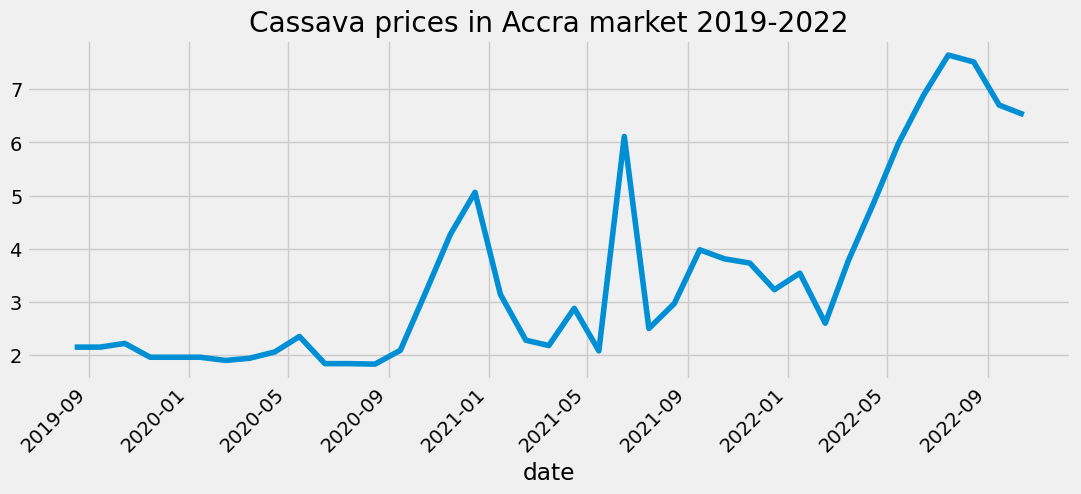

In [100]:
plt.figure(figsize=(12, 5))
cassava_accra.plot()
plt.title("Cassava prices in Accra market 2019-2022")
plt.xticks(rotation=45)
plt.show()

In [101]:
cassava_accra_df =cassava_accra.reset_index()

In [102]:
# Splitting the data
cassava_accra_train = cassava_accra[:'2022-01-01'].values
cassava_accra_test = cassava_accra['2022-01-01':].values

<Figure size 1200x600 with 0 Axes>

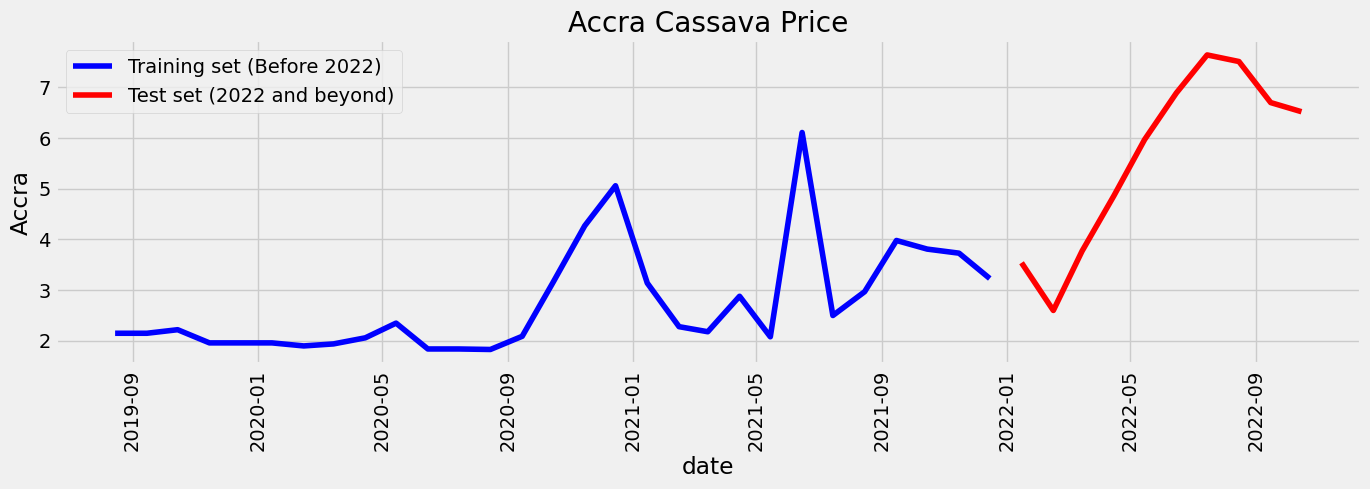

In [103]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
plt.figure(figsize=(12,6))
fig, ax = plt.subplots(1, 1, figsize=(15,4))
a = sns.lineplot(x =cassava_accra[:'2022-01-01'].index, y = cassava_accra[:'2022-01-01'], label = 'Training set (Before 2022)', color = 'blue', ax=ax)
b = sns.lineplot(x =cassava_accra['2022-01-01':].index, y = cassava_accra['2022-01-01':], label = 'Test set (2022 and beyond)',
               color = 'red', ax=ax)
plt.title('Accra Cassava Price')
plt.xticks(rotation=90)
plt.show()

In [104]:
# # Scaling the training set
# sc = MinMaxScaler(
#     feature_range=(0,1)
#                  )
# cassava_accra_train_scaled = sc.fit_transform(cassava_accra_train.reshape(1,-1)).reshape((-1, 1))

In [105]:
cassava_accra_train = cassava_accra_train.reshape((-1, 1))

In [106]:
# Since LSTMs store long term memory state, we create a data structure with 12 timesteps and 1 output
# So for each element of training set, we have 12 previous training set elements 
X_train = []
y_train = []
for i in range(12,cassava_accra_train.shape[0]):
    X_train.append(cassava_accra_train[i-12:i,0])
    y_train.append(cassava_accra_train[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [107]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM Model

In [108]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# # Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=16, validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 11.1048 - val_loss: 10.9146
Epoch 2/50
1/1 [==============================] - 0s 76ms/step - loss: 9.4230 - val_loss: 7.6002
Epoch 3/50
1/1 [==============================] - 0s 77ms/step - loss: 6.9129 - val_loss: 3.3397
Epoch 4/50
1/1 [==============================] - 0s 80ms/step - loss: 3.8273 - val_loss: 0.5565
Epoch 5/50
1/1 [==============================] - 0s 88ms/step - loss: 2.5042 - val_loss: 0.1022
Epoch 6/50
1/1 [==============================] - 0s 78ms/step - loss: 1.8339 - val_loss: 0.3338
Epoch 7/50
1/1 [==============================] - 0s 80ms/step - loss: 1.5800 - val_loss: 0.1034
Epoch 8/50
1/1 [==============================] - 0s 75ms/step - loss: 2.2477 - val_loss: 0.3138
Epoch 9/50
1/1 [==============================] - 0s 85ms/step - loss: 1.4505 - val_loss: 0.1348
Epoch 10/50
1/1 [==============================] - 0s 86ms/step - loss: 1.8135 - val_loss: 0.2037
Epoch 11/50
1/1 [==========

In [109]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 12 entires of test set have 12 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
inputs = cassava_accra[len(cassava_accra)-len(cassava_accra_test) - 12:].values
inputs = inputs.reshape(-1,1)

In [110]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(12,inputs.shape[0]):
    X_test.append(inputs[i-12:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_cassava_accra_price = regressor.predict(X_test)
# predicted_cassava_accra_price = sc.inverse_transform(predicted_cassava_accra_price)

1/1 [==============================] - 2s 2s/step


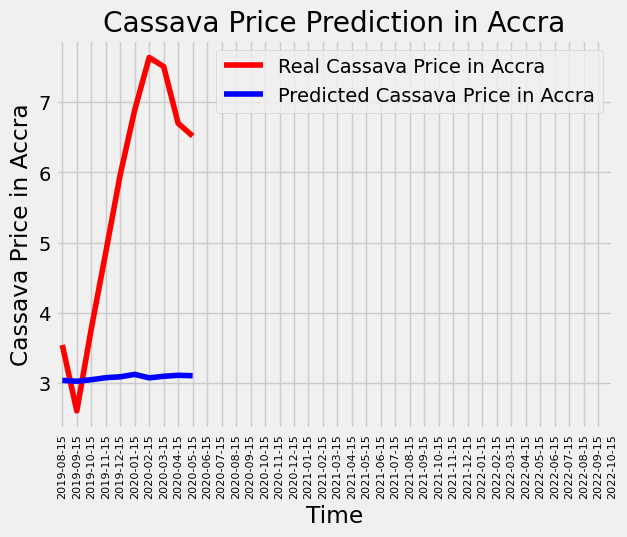

In [111]:
# Visualizing the results for LSTM
plot_predictions(cassava_accra_test,predicted_cassava_accra_price, "Cassava", "Accra")

In [112]:
# Evaluating our model
return_rmse(cassava_accra_test,predicted_cassava_accra_price)

3.027186010026138

## Prophet Model

In [113]:
cassava_accra_df.columns = ["ds", "y"]

In [114]:
# cassava_accra_df.ds = cassava_accra_df.ds.astype(str).apply(lambda x: x.replace("-15", ""))

In [115]:
# cassava_accra_df.ds = pd.to_datetime(cassava_accra_df.ds, format="%Y-%m").dt.strftime('%Y-%m')

In [116]:
m = Prophet()
m.fit(cassava_accra_df.loc[cassava_accra_df.ds<"2022-04"])  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=8, freq="M", include_history=True)
prediction = m.predict(future)

22:08:35 - cmdstanpy - INFO - Chain [1] start processing
22:08:36 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-15,2.309953,1.454997,2.623701,2.309953,2.309953,-0.281386,-0.281386,-0.281386,-0.281386,-0.281386,-0.281386,0.0,0.0,0.0,2.028567
1,2019-09-15,2.380096,1.800437,2.926230,2.380096,2.380096,-0.053381,-0.053381,-0.053381,-0.053381,-0.053381,-0.053381,0.0,0.0,0.0,2.326716
2,2019-10-15,2.447977,1.770905,2.923602,2.447977,2.447977,-0.108330,-0.108330,-0.108330,-0.108330,-0.108330,-0.108330,0.0,0.0,0.0,2.339647
3,2019-11-15,2.518120,1.435727,2.618126,2.518120,2.518120,-0.468376,-0.468376,-0.468376,-0.468376,-0.468376,-0.468376,0.0,0.0,0.0,2.049744
4,2019-12-15,2.586001,1.342992,2.452597,2.586001,2.586001,-0.674380,-0.674380,-0.674380,-0.674380,-0.674380,-0.674380,0.0,0.0,0.0,1.911621
5,2020-01-15,2.656144,1.747492,2.782841,2.656144,2.656144,-0.405078,-0.405078,-0.405078,-0.405078,-0.405078,-0.405078,0.0,0.0,0.0,2.251066
6,2020-02-15,2.726288,1.509240,2.661334,2.726288,2.726288,-0.654018,-0.654018,-0.654018,-0.654018,-0.654018,-0.654018,0.0,0.0,0.0,2.072269
7,2020-03-15,2.791905,0.862202,2.038122,2.791905,2.791905,-1.316340,-1.316340,-1.316340,-1.316340,-1.316340,-1.316340,0.0,0.0,0.0,1.475565
8,2020-04-15,2.862049,1.531612,2.690456,2.862049,2.862049,-0.777070,-0.777070,-0.777070,-0.777070,-0.777070,-0.777070,0.0,0.0,0.0,2.084979
9,2020-05-15,2.929930,2.166508,3.277424,2.929930,2.929930,-0.209387,-0.209387,-0.209387,-0.209387,-0.209387,-0.209387,0.0,0.0,0.0,2.720543


In [118]:
cassava_accra_df.ds = cassava_accra_df.ds.astype(str).apply(lambda x: x.replace("-15", ""))

cassava_accra_df.ds = pd.to_datetime(cassava_accra_df.ds, format="%Y-%m").dt.strftime('%Y-%m')

In [119]:
prediction.ds = prediction.ds.astype(str).apply(lambda x: x.replace("-15", ""))

prediction.ds = pd.to_datetime(prediction.ds, format="%Y-%m").dt.strftime('%Y-%m')

In [120]:
prediction = prediction.drop(31).reset_index(drop=True)

In [121]:
cassava_accra_df

,ds,y
0,2019-08,2.15
1,2019-09,2.15
2,2019-10,2.22
3,2019-11,1.96
4,2019-12,1.96
5,2020-01,1.96
6,2020-02,1.90
7,2020-03,1.94
8,2020-04,2.06
9,2020-05,2.35


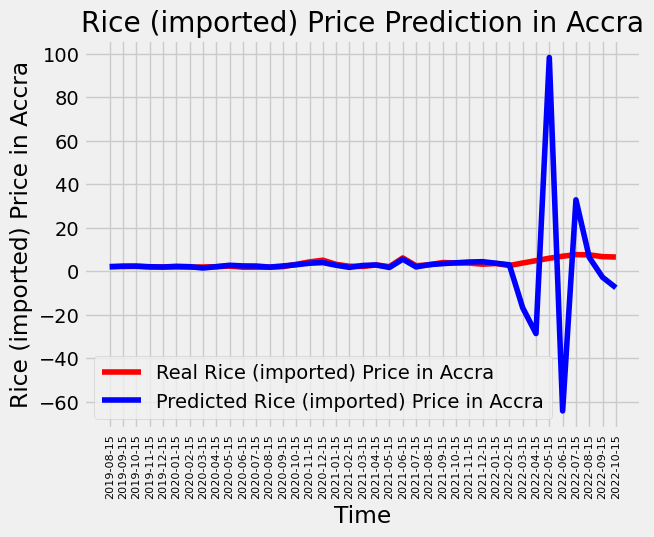

In [122]:
# Visualizing the results for LSTM
plot_predictions(cassava_accra_df.y.values,prediction.yhat.values, "Rice (imported)", "Accra")

In [42]:
# Evaluating our model
return_rmse(cassava_accra_df.y.values,prediction.yhat.values)

20.31538259229235

In [43]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08,2.309953,1.454997,2.623701,2.309953,2.309953,-0.281386,-0.281386,-0.281386,-0.281386,-0.281386,-0.281386,0.0,0.0,0.0,2.028567
1,2019-09,2.380096,1.800437,2.926230,2.380096,2.380096,-0.053381,-0.053381,-0.053381,-0.053381,-0.053381,-0.053381,0.0,0.0,0.0,2.326716
2,2019-10,2.447977,1.770905,2.923602,2.447977,2.447977,-0.108330,-0.108330,-0.108330,-0.108330,-0.108330,-0.108330,0.0,0.0,0.0,2.339647
3,2019-11,2.518120,1.435727,2.618126,2.518120,2.518120,-0.468376,-0.468376,-0.468376,-0.468376,-0.468376,-0.468376,0.0,0.0,0.0,2.049744
4,2019-12,2.586001,1.342992,2.452597,2.586001,2.586001,-0.674380,-0.674380,-0.674380,-0.674380,-0.674380,-0.674380,0.0,0.0,0.0,1.911621
5,2020-01,2.656144,1.747492,2.782841,2.656144,2.656144,-0.405078,-0.405078,-0.405078,-0.405078,-0.405078,-0.405078,0.0,0.0,0.0,2.251066
6,2020-02,2.726288,1.509240,2.661334,2.726288,2.726288,-0.654018,-0.654018,-0.654018,-0.654018,-0.654018,-0.654018,0.0,0.0,0.0,2.072269
7,2020-03,2.791905,0.862202,2.038122,2.791905,2.791905,-1.316340,-1.316340,-1.316340,-1.316340,-1.316340,-1.316340,0.0,0.0,0.0,1.475565
8,2020-04,2.862049,1.531612,2.690456,2.862049,2.862049,-0.777070,-0.777070,-0.777070,-0.777070,-0.777070,-0.777070,0.0,0.0,0.0,2.084979
9,2020-05,2.929930,2.166508,3.277424,2.929930,2.929930,-0.209387,-0.209387,-0.209387,-0.209387,-0.209387,-0.209387,0.0,0.0,0.0,2.720543


## Generalization

In [44]:
def predict_price_by_market_and_commodity(market, commodity):
    commodity_markets = wfp_ghana_ret.loc[wfp_ghana_ret.commodity==commodity].pivot(index="date", columns="market", values="price").reset_index()
    
    commodity_markets.date = commodity_markets.date.astype(str).apply(lambda x: x.replace("-15", ""))
    commodity_markets.date = pd.to_datetime(commodity_markets.date, format="%Y-%m").dt.strftime('%Y-%m')

    commodity_markets = commodity_markets.set_index("date")

    extra = pd.DataFrame(pd.Series(pd.date_range("2019-08-15", "2022-10-15", freq="M").astype(str)).apply(lambda x: x[:7]))
    extra["new"] ="hello"
    extra.columns=["date", "new"]
    extra = extra.set_index("date")

    commodity_markets = extra.join(commodity_markets)

    commodity_markets = commodity_markets.drop("new", axis=1)
    
    market_commodity = commodity_markets[market]
    
    market_commodity = market_commodity.ffill()
    
    market_commodity_df =market_commodity.reset_index()
    
    market_commodity_df.columns = ["ds", "y"]
    
    m = Prophet()
    m.fit(market_commodity_df.loc[market_commodity_df.ds<"2022-04"])  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = m.make_future_dataframe(periods=8, freq="M", include_history=True)
    prediction = m.predict(future)
    
    market_commodity_df.ds = market_commodity_df.ds.astype(str).apply(lambda x: x.replace("-15", ""))

    market_commodity_df.ds = pd.to_datetime(market_commodity_df.ds, format="%Y-%m").dt.strftime('%Y-%m')

    prediction.ds = prediction.ds.astype(str).apply(lambda x: x.replace("-15", ""))

    prediction.ds = pd.to_datetime(prediction.ds, format="%Y-%m").dt.strftime('%Y-%m')

    prediction = prediction.drop(31).reset_index(drop=True)
    
    return cassava_accra_df.y.values, prediction.yhat.values
    

In [123]:
y, y_hat = predict_price_by_market_and_commodity("Kumasi", "Rice (imported)")

23:07:01 - cmdstanpy - INFO - Chain [1] start processing
23:07:01 - cmdstanpy - INFO - Chain [1] done processing


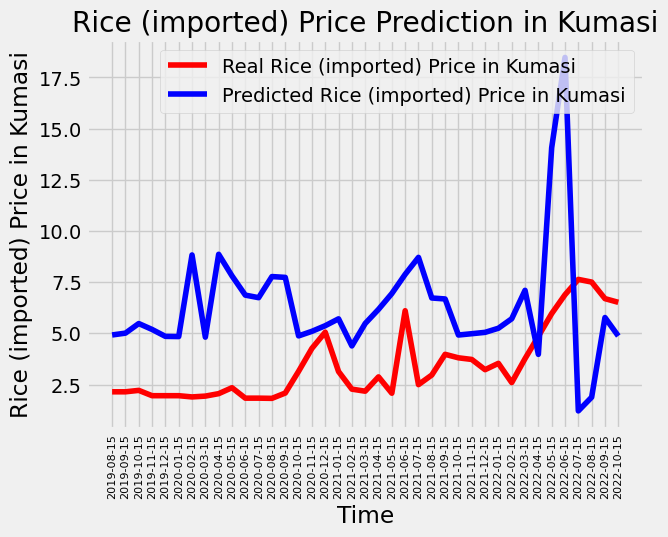

In [124]:
# Visualizing the results for LSTM
plot_predictions(y, np.abs(y_hat), "Rice (imported)", "Kumasi")

In [78]:
# Evaluating our model
return_rmse(y,np.abs(y_hat))

8.529561500476342

In [48]:
markets_with_issues = []

for commodity in wfp_ghana.commodity.unique():
#     print(commodity, ":\n")
    markets_with_issues.extend(wfp_ghana_ret.loc[wfp_ghana_ret.commodity==commodity].pivot(index="date", columns="market", values="price").isna().sum()[wfp_ghana_ret.loc[wfp_ghana_ret.commodity==commodity].pivot(index="date", columns="market", values="price").isna().sum()>30].index.tolist())

In [49]:
np.unique(markets_with_issues)

array(['Ejura', 'Koforidua', 'Mankessim', 'Nkwanta', 'Tema', 'Yendi'],
      dtype='<U9')

In [50]:
markets = []
commodities = []
errors = []

unusual_markets = []

unusual_commodities = []

for market in tqdm(wfp_ghana_ret.market.unique()):
    
#     if market not in markets_with_issues:
    
    for commodity in tqdm(wfp_ghana_ret.commodity.unique()):

        try:
            y, y_hat = predict_price_by_market_and_commodity(market, commodity)

            errors.append(return_rmse(y,y_hat))

            markets.append(market)

            commodities.append(commodity)

        except KeyError:
            print(market, commodity)
            unusual_markets.append(market)
            unusual_commodities.append(commodity)
        except ValueError:
            print(market, commodity)

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 1/22 [00:01<00:21,  1.04s/it]21:38:58 - cmdstanpy - INFO - Chain [1] start processing
21:38:58 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:02<00:23,  1.17s/it]21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:03<00:21,  1.12s/it]21:39:00 - cmdstanpy - INFO - Chain [1] start processing
21:39:01 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                

 50%|█████████████████████████████████████████                                         | 11/22 [00:13<00:13,  1.20s/it]21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:14<00:12,  1.21s/it]21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:15<00:10,  1.17s/it]21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:16<00:09,  1.13s/it]21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉       

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]21:40:06 - cmdstanpy - INFO - Chain [1] start processing
21:40:06 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 1/22 [00:00<00:19,  1.09it/s]21:40:07 - cmdstanpy - INFO - Chain [1] start processing
21:40:07 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:17,  1.16it/s]21:40:08 - cmdstanpy - INFO - Chain [1] start processing
21:40:08 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:18,  1.05it/s]21:40:09 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                

21:40:38 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:11<00:09,  1.02it/s]21:40:39 - cmdstanpy - INFO - Chain [1] start processing
21:40:39 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:12<00:08,  1.07it/s]21:40:40 - cmdstanpy - INFO - Chain [1] start processing
21:40:40 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:13<00:06,  1.14it/s]21:40:40 - cmdstanpy - INFO - Chain [1] start processing
21:40:41 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:13<00:06,  1.13it/s]21:40:41 - cmdstanpy - INFO - Chain [1] start processing
21:40:42 - cmdstanpy - INFO - Chain [1] done processing

 73%|██████

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 1/22 [00:00<00:17,  1.19it/s]21:41:07 - cmdstanpy - INFO - Chain [1] start processing
21:41:07 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:17,  1.16it/s]21:41:08 - cmdstanpy - INFO - Chain [1] start processing
21:41:08 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:18,  1.01it/s]21:41:09 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:09<00:08,  1.24it/s]21:41:35 - cmdstanpy - INFO - Chain [1] start processing
21:41:35 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:10<00:07,  1.28it/s]21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:11<00:06,  1.23it/s]21:41:37 - cmdstanpy - INFO - Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:12<00:05,  1.29it/s]21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████▋   

  5%|███▊                                                                               | 1/22 [00:00<00:18,  1.14it/s]21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:04 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:16,  1.22it/s]21:42:04 - cmdstanpy - INFO - Chain [1] start processing
21:42:05 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:17,  1.09it/s]21:42:05 - cmdstanpy - INFO - Chain [1] start processing
21:42:06 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                                    | 4/22 [00:03<00:15,  1.13it/s]21:42:06 - cmdstanpy - INFO - Chain [1] start processing
21:42:06 - cmdstanpy - INFO - Chain [1] done processing

 23%|██████████████████▊                                            

21:42:33 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:11<00:07,  1.23it/s]21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:11<00:06,  1.17it/s]21:42:34 - cmdstanpy - INFO - Chain [1] start processing
21:42:34 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:12<00:05,  1.22it/s]21:42:35 - cmdstanpy - INFO - Chain [1] start processing
21:42:35 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:13<00:04,  1.23it/s]21:42:36 - cmdstanpy - INFO - Chain [1] start processing
21:42:36 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████

  5%|███▊                                                                               | 1/22 [00:00<00:19,  1.07it/s]21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:01 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:18,  1.09it/s]21:43:01 - cmdstanpy - INFO - Chain [1] start processing
21:43:01 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:18,  1.05it/s]21:43:02 - cmdstanpy - INFO - Chain [1] start processing


Yendi Maize (yellow)


21:43:02 - cmdstanpy - INFO - Chain [1] done processing

 23%|██████████████████▊                                                                | 5/22 [00:03<00:11,  1.49it/s]21:43:03 - cmdstanpy - INFO - Chain [1] start processing
21:43:03 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████▋                                                            | 6/22 [00:04<00:11,  1.43it/s]21:43:04 - cmdstanpy - INFO - Chain [1] start processing
21:43:04 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:12,  1.18it/s]21:43:05 - cmdstanpy - INFO - Chain [1] start processing
21:43:05 - cmdstanpy - INFO - Chain [1] done processing

 36%|██████████████████████████████▏                                                    | 8/22 [00:06<00:11,  1.20it/s]21:43:06 - cmdstanpy - INFO - Chain [1] start processing
21:43:06 - cmdstanpy - INFO - Chain [1] done processing

 41%|██████


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:15<00:04,  1.09it/s]21:43:33 - cmdstanpy - INFO - Chain [1] start processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:15<00:03,  1.17it/s]21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing

 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:16<00:02,  1.24it/s]21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing

 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:17<00:01,  1.10it/s]21:43:36 - cmdstanpy - INFO - Chain [1] start processing
21:43:36 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████

21:44:02 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████▋                                                            | 6/22 [00:05<00:14,  1.11it/s]21:44:02 - cmdstanpy - INFO - Chain [1] start processing
21:44:03 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████▍                                                        | 7/22 [00:06<00:13,  1.12it/s]21:44:03 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing

 36%|██████████████████████████████▏                                                    | 8/22 [00:07<00:12,  1.10it/s]21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████▉                                                 | 9/22 [00:08<00:11,  1.10it/s]21:44:05 - cmdstanpy - INFO - Chain [1] start processing
21:44:05 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████

 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:14<00:04,  1.17it/s]21:44:31 - cmdstanpy - INFO - Chain [1] start processing
21:44:31 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:15<00:03,  1.14it/s]21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:32 - cmdstanpy - INFO - Chain [1] done processing

 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:16<00:02,  1.23it/s]21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:32 - cmdstanpy - INFO - Chain [1] done processing

 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:16<00:01,  1.20it/s]21:44:33 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████

21:44:59 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████▋                                                            | 6/22 [00:04<00:12,  1.27it/s]21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.29it/s]21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing

 36%|██████████████████████████████▏                                                    | 8/22 [00:06<00:10,  1.29it/s]21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:02 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████▉                                                 | 9/22 [00:07<00:11,  1.12it/s]21:45:03 - cmdstanpy - INFO - Chain [1] start processing
21:45:03 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████

Nkwanta Cassava
Nkwanta Gari



 23%|██████████████████▊                                                                | 5/22 [00:00<00:02,  8.41it/s]

Nkwanta Maize
Nkwanta Maize (yellow)
Nkwanta Millet



 27%|██████████████████████▋                                                            | 6/22 [00:00<00:02,  7.72it/s]


Nkwanta Rice (imported)
Nkwanta Rice (local)


 41%|█████████████████████████████████▉                                                 | 9/22 [00:01<00:01,  6.78it/s]

Nkwanta Sorghum
Nkwanta Yam



 50%|█████████████████████████████████████████                                         | 11/22 [00:01<00:01,  6.87it/s]

Nkwanta Fish (mackerel, fresh)
Nkwanta Cowpeas



 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:01<00:01,  6.57it/s]

Nkwanta Soybeans
Nkwanta Eggplants



 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:02<00:01,  6.94it/s]

Nkwanta Onions
Nkwanta Peppers (dried)



 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:02<00:00,  6.98it/s]

Nkwanta Peppers (fresh)
Nkwanta Plantains (apem)



 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:02<00:00,  6.72it/s]


Nkwanta Plantains (apentu)
Nkwanta Tomatoes (local)


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:03<00:00,  6.35it/s]

Nkwanta Tomatoes (navrongo)
Nkwanta Yam (puna)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:21<00:00, 19.05s/it]

Nkwanta Meat (chicken)


In [51]:
[len(x) for x in [markets, commodities, errors]]

[417, 417, 417]

In [52]:
np.unique(unusual_markets)

array(['Nkwanta', 'Yendi'], dtype='<U7')

In [53]:
np.unique(unusual_commodities)

array(['Maize (yellow)'], dtype='<U14')

In [54]:
pd.DataFrame({
    "market":markets,
    "commodity":commodities,
    "errors":errors
}).sort_values("errors")

,market,commodity,errors
201,Accra,Maize (yellow),1.055677
135,Cape Coast,Maize (yellow),1.056744
375,Sekondi/Takoradi,Maize,1.091884
246,Tamale,Millet,1.130676
249,Tamale,Sorghum,1.158060
...,...,...,...
233,Tema,Onions,28.758919
229,Tema,"Fish (mackerel, fresh)",29.739406
141,Cape Coast,"Fish (mackerel, fresh)",29.873726
211,Accra,Onions,31.619296


In [55]:
pd.DataFrame({
    "market":markets,
    "commodity":commodities,
    "errors":errors
}).sort_values("errors").to_csv("../data/prices_predictions_errors.csv", index=False)

In [56]:
def predict_price_by_market_and_commodity2(market, commodity):
    commodity_markets = wfp_ghana_ret.loc[wfp_ghana_ret.commodity==commodity].pivot(index="date", columns="market", values="price").reset_index()
    
    commodity_markets.date = commodity_markets.date.astype(str).apply(lambda x: x.replace("-15", ""))
    commodity_markets.date = pd.to_datetime(commodity_markets.date, format="%Y-%m").dt.strftime('%Y-%m')

    commodity_markets = commodity_markets.set_index("date")

    extra = pd.DataFrame(pd.Series(pd.date_range("2019-08-15", "2022-10-15", freq="M").astype(str)).apply(lambda x: x[:7]))
    extra["new"] ="hello"
    extra.columns=["date", "new"]
    extra = extra.set_index("date")

    commodity_markets = extra.join(commodity_markets)

    commodity_markets = commodity_markets.drop("new", axis=1)
    
    market_commodity = commodity_markets[market]
    
    market_commodity = market_commodity.ffill()
    
    market_commodity_df =market_commodity.reset_index()
    
    market_commodity_df.columns = ["ds", "y"]
    
    m = Prophet()
    m.fit(market_commodity_df.loc[market_commodity_df.ds<"2022-04"], )  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = m.make_future_dataframe(periods=10, freq="M", include_history=False)
    prediction = m.predict(future)
    
    prediction.ds = prediction.ds.astype(str).apply(lambda x: x[:7])

    prediction.ds = pd.to_datetime(prediction.ds, format="%Y-%m").dt.strftime('%Y-%m')
    
    return prediction.loc[prediction.ds>="2022-11"]
    

In [57]:
predict_price_by_market_and_commodity2("Kumasi", "Onions").yhat.values

21:45:18 - cmdstanpy - INFO - Chain [1] start processing
21:45:18 - cmdstanpy - INFO - Chain [1] done processing


array([ 0.2110416 , -3.19893273])

In [58]:
markets = []
commodities = []
november_prices = []
december_prices = []

for market in tqdm(wfp_ghana_ret.market.unique()):
    
#     if market not in markets_with_issues:
    
        for commodity in tqdm(wfp_ghana_ret.commodity.unique()):

            try:
                prediction = predict_price_by_market_and_commodity2(market, commodity)

                november_prices.append(np.abs(prediction.yhat.values[0]))
                
                december_prices.append(np.abs(prediction.yhat.values[1]))
                
                markets.append(market)

                commodities.append(commodity)
                
            except KeyError:
                print(market, commodity)
                unusual_markets.append(market)
                unusual_commodities.append(commodity)
            except ValueError:
                print(market, commodity)


  0%|                                                                                           | 0/22 [00:00<?, ?it/s]21:45:19 - cmdstanpy - INFO - Chain [1] start processing
21:45:19 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 1/22 [00:00<00:18,  1.12it/s]21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:17,  1.17it/s]21:45:21 - cmdstanpy - INFO - Chain [1] start processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:16,  1.18it/s]21:45:21 - cmdstanpy - INFO - Chain [1] start processing
21:45:22 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                

 50%|█████████████████████████████████████████                                         | 11/22 [00:09<00:09,  1.21it/s]21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:09<00:07,  1.29it/s]21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:48 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:10<00:07,  1.22it/s]21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:11<00:06,  1.28it/s]21:45:49 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉       

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 1/22 [00:00<00:13,  1.51it/s]21:46:13 - cmdstanpy - INFO - Chain [1] start processing
21:46:14 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:16,  1.21it/s]21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:15,  1.19it/s]21:46:15 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                

21:46:40 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:09<00:08,  1.24it/s]21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:10<00:07,  1.28it/s]21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:11<00:06,  1.30it/s]21:46:42 - cmdstanpy - INFO - Chain [1] start processing
21:46:42 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:12<00:05,  1.26it/s]21:46:43 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing

 73%|██████

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing

  5%|███▊                                                                               | 1/22 [00:00<00:19,  1.08it/s]21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:16,  1.21it/s]21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:08 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:16,  1.15it/s]21:47:09 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                

 55%|████████████████████████████████████████████▋                                     | 12/22 [00:09<00:07,  1.26it/s]21:47:34 - cmdstanpy - INFO - Chain [1] start processing
21:47:34 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:10<00:06,  1.32it/s]21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:10<00:05,  1.35it/s]21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:11<00:05,  1.30it/s]21:47:36 - cmdstanpy - INFO - Chain [1] start processing
21:47:36 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████▋   

  5%|███▊                                                                               | 1/22 [00:00<00:20,  1.01it/s]21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:17,  1.15it/s]21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:16,  1.16it/s]21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████                                                                    | 4/22 [00:03<00:16,  1.12it/s]21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] done processing

 23%|██████████████████▊                                            

21:48:28 - cmdstanpy - INFO - Chain [1] done processing

 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:11<00:07,  1.16it/s]21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing

 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:12<00:07,  1.11it/s]21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:30 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:12<00:05,  1.19it/s]21:48:31 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:13<00:04,  1.22it/s]21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:32 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████

  5%|███▊                                                                               | 1/22 [00:00<00:17,  1.18it/s]21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████▌                                                                           | 2/22 [00:01<00:18,  1.07it/s]21:48:57 - cmdstanpy - INFO - Chain [1] start processing
21:48:57 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████▎                                                                       | 3/22 [00:02<00:16,  1.16it/s]21:48:58 - cmdstanpy - INFO - Chain [1] start processing


Yendi Maize (yellow)


21:48:58 - cmdstanpy - INFO - Chain [1] done processing

 23%|██████████████████▊                                                                | 5/22 [00:03<00:10,  1.67it/s]21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████▋                                                            | 6/22 [00:04<00:10,  1.50it/s]21:49:00 - cmdstanpy - INFO - Chain [1] start processing
21:49:00 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:11,  1.34it/s]21:49:00 - cmdstanpy - INFO - Chain [1] start processing
21:49:01 - cmdstanpy - INFO - Chain [1] done processing

 36%|██████████████████████████████▏                                                    | 8/22 [00:05<00:10,  1.31it/s]21:49:01 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing

 41%|██████


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:13<00:04,  1.24it/s]21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:14<00:03,  1.19it/s]21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing

 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:15<00:02,  1.27it/s]21:49:29 - cmdstanpy - INFO - Chain [1] start processing
21:49:29 - cmdstanpy - INFO - Chain [1] done processing

 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:16<00:01,  1.17it/s]21:49:30 - cmdstanpy - INFO - Chain [1] start processing
21:49:30 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████

21:49:54 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████▋                                                            | 6/22 [00:04<00:12,  1.23it/s]21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:55 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:13,  1.14it/s]21:49:55 - cmdstanpy - INFO - Chain [1] start processing
21:49:56 - cmdstanpy - INFO - Chain [1] done processing

 36%|██████████████████████████████▏                                                    | 8/22 [00:06<00:13,  1.07it/s]21:49:56 - cmdstanpy - INFO - Chain [1] start processing
21:49:57 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████▉                                                 | 9/22 [00:07<00:11,  1.12it/s]21:49:57 - cmdstanpy - INFO - Chain [1] start processing
21:49:57 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████

 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:13<00:04,  1.24it/s]21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:14<00:03,  1.21it/s]21:50:23 - cmdstanpy - INFO - Chain [1] start processing
21:50:23 - cmdstanpy - INFO - Chain [1] done processing

 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:15<00:02,  1.21it/s]21:50:24 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing

 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [00:16<00:01,  1.24it/s]21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████

21:50:51 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████▋                                                            | 6/22 [00:04<00:13,  1.20it/s]21:50:52 - cmdstanpy - INFO - Chain [1] start processing
21:50:52 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████▍                                                        | 7/22 [00:05<00:12,  1.23it/s]21:50:53 - cmdstanpy - INFO - Chain [1] start processing
21:50:53 - cmdstanpy - INFO - Chain [1] done processing

 36%|██████████████████████████████▏                                                    | 8/22 [00:06<00:12,  1.15it/s]21:50:54 - cmdstanpy - INFO - Chain [1] start processing
21:50:54 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████▉                                                 | 9/22 [00:07<00:11,  1.16it/s]21:50:55 - cmdstanpy - INFO - Chain [1] start processing
21:50:55 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████

Nkwanta Cassava



  9%|███████▌                                                                           | 2/22 [00:00<00:04,  4.36it/s]

Nkwanta Gari



 14%|███████████▎                                                                       | 3/22 [00:00<00:04,  4.59it/s]


Nkwanta Maize
Nkwanta Maize (yellow)
Nkwanta Millet


 32%|██████████████████████████▍                                                        | 7/22 [00:01<00:02,  6.56it/s]

Nkwanta Rice (imported)
Nkwanta Rice (local)



 41%|█████████████████████████████████▉                                                 | 9/22 [00:01<00:01,  6.71it/s]

Nkwanta Sorghum
Nkwanta Yam



 45%|█████████████████████████████████████▎                                            | 10/22 [00:01<00:01,  6.95it/s]

Nkwanta Fish (mackerel, fresh)



 50%|█████████████████████████████████████████                                         | 11/22 [00:01<00:02,  4.92it/s]

Nkwanta Cowpeas



 55%|████████████████████████████████████████████▋                                     | 12/22 [00:02<00:02,  3.92it/s]

Nkwanta Soybeans



 59%|████████████████████████████████████████████████▍                                 | 13/22 [00:02<00:02,  4.04it/s]

Nkwanta Eggplants



 64%|████████████████████████████████████████████████████▏                             | 14/22 [00:02<00:02,  3.62it/s]

Nkwanta Onions



 68%|███████████████████████████████████████████████████████▉                          | 15/22 [00:03<00:01,  3.57it/s]

Nkwanta Peppers (dried)



 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [00:03<00:01,  3.85it/s]

Nkwanta Peppers (fresh)



 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [00:03<00:01,  3.73it/s]

Nkwanta Plantains (apem)



 82%|███████████████████████████████████████████████████████████████████               | 18/22 [00:03<00:01,  3.80it/s]

Nkwanta Plantains (apentu)



 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [00:04<00:00,  4.03it/s]


Nkwanta Tomatoes (local)
Nkwanta Tomatoes (navrongo)


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [00:04<00:00,  4.76it/s]

Nkwanta Yam (puna)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:51<00:00, 17.57s/it]

Nkwanta Meat (chicken)


In [59]:
forecast = pd.DataFrame({
    "market": markets,
    "commodity": commodities,
    "november_prices": november_prices,
    "december_prices": december_prices
})
forecast

,market,commodity,november_prices,december_prices
0,Ejura,Cassava,6.603772,7.881129
1,Ejura,Gari,4.780119,4.575771
2,Ejura,Maize,2.603330,2.365105
3,Ejura,Maize (yellow),3.085164,3.165122
4,Ejura,Millet,3.647029,3.597504
...,...,...,...,...
412,Hohoe,Plantains (apentu),4.363115,0.888922
413,Hohoe,Tomatoes (local),2.491479,1.896450
414,Hohoe,Tomatoes (navrongo),1.846373,0.659054
415,Hohoe,Yam (puna),4.022121,3.272579


In [60]:
forecast = pd.melt(forecast, id_vars=["market", "commodity"], value_vars=["november_prices", "december_prices"])

In [61]:
forecast.columns = ["market", "commodity", "date", "price"]
forecast.date = forecast.date.replace("november_prices", "2022-11-15").replace("december_prices", "2022-12-15")

In [62]:
forecast.to_csv("../data/forecast.csv", index=False)

In [63]:
forecast.sort_values(["market", "commodity", "date"])

,market,commodity,date,price
198,Accra,Cassava,2022-11-15,3.143584
615,Accra,Cassava,2022-12-15,5.093800
208,Accra,Cowpeas,2022-11-15,6.838978
625,Accra,Cowpeas,2022-12-15,7.935581
210,Accra,Eggplants,2022-11-15,0.410600
...,...,...,...,...
699,Yendi,Tomatoes (navrongo),2022-12-15,2.417537
271,Yendi,Yam,2022-11-15,3.136863
688,Yendi,Yam,2022-12-15,6.030717
283,Yendi,Yam (puna),2022-11-15,3.298393
